# Creating a fully connected neural network

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from IPython.display import Image
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets.

In [2]:
# Define the device (use GPU if available)
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(f'Using device: {device}')

Using device: cuda:4


Network specs for the layers to make easy edits

In [3]:
file_name = "256_AI_And_Classes_features.npz"

data = np.load(f"Features/{file_name}")
features = data['features']
labels = data['labels']

X = features
y = labels

print(X.shape)
print(y.shape)

# Get the number of unique classes
num_classes = len(np.unique(y))
print("Number of classes:", num_classes)

(185015, 32768)
(185015,)
Number of classes: 20


In [4]:
# Network Specs
input_size = X.shape[1]  # image data size
output_size = num_classes
layer_sizes = [input_size, input_size//2, input_size//4, input_size // 8, input_size // 16, input_size // 32, input_size // 64,output_size]
print(layer_sizes)
# Training parameters
batch_size = 512
epochs = 50
lrate = 0.01

[32768, 16384, 8192, 4096, 2048, 1024, 512, 20]


In [5]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

        # Create a list to hold the layers
        layers = []

        # Hidden layers
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:  # Don't add ReLU after the last hidden layer
                layers.append(nn.ReLU())
        
        # Combine all layers into a Sequential module
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, input_size)
        return self.network(x)

In [6]:
# Split into testing and training data
X, X_test, y, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

X_tensor = torch.tensor(X, dtype=torch.float32)  # Ensure dtype is appropriate for your data
y_tensor = torch.tensor(y, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Ensure dtype is appropriate for your data
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create PyTorch Datasets and DataLoaders for training
train_dataset = TensorDataset(X_tensor, y_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)  # Do the same for your test data


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print('Data loaders created successfully.')

Data loaders created successfully.


In [7]:
#instantiate the model, while also defining loss function & optimizer
model = NeuralNet().to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lrate)

NeuralNet(
  (network): Sequential(
    (0): Linear(in_features=32768, out_features=16384, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16384, out_features=8192, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8192, out_features=4096, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4096, out_features=2048, bias=True)
    (7): ReLU()
    (8): Linear(in_features=2048, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=20, bias=True)
  )
)


Epoch [1/50], Loss: 34512.7619
Epoch [2/50], Loss: 11.5374
Epoch [3/50], Loss: 2.9327
Epoch [4/50], Loss: 2.9324
Epoch [5/50], Loss: 2.9327
Epoch [6/50], Loss: 2.9328
Epoch [7/50], Loss: 2.9328
Epoch [8/50], Loss: 2.9327
Epoch [9/50], Loss: 2.9327
Epoch [10/50], Loss: 2.9330
Epoch [11/50], Loss: 2.9330
Epoch [12/50], Loss: 2.9328
Epoch [13/50], Loss: 2.9326
Epoch [14/50], Loss: 2.9328
Epoch [15/50], Loss: 2.9327
Epoch [16/50], Loss: 2.9328
Epoch [17/50], Loss: 2.9328
Epoch [18/50], Loss: 2.9327
Epoch [19/50], Loss: 2.9327
Epoch [20/50], Loss: 2.9327
Epoch [21/50], Loss: 2.9329
Epoch [22/50], Loss: 2.9331
Epoch [23/50], Loss: 2.9330
Epoch [24/50], Loss: 2.9333
Epoch [25/50], Loss: 2.9328
Epoch [26/50], Loss: 2.9326
Epoch [27/50], Loss: 2.9327
Epoch [28/50], Loss: 2.9329
Epoch [29/50], Loss: 2.9327
Epoch [30/50], Loss: 2.9327
Epoch [31/50], Loss: 2.9327
Epoch [32/50], Loss: 2.9329
Epoch [33/50], Loss: 2.9330
Epoch [34/50], Loss: 2.9331
Epoch [35/50], Loss: 2.9329
Epoch [36/50], Loss: 2.9

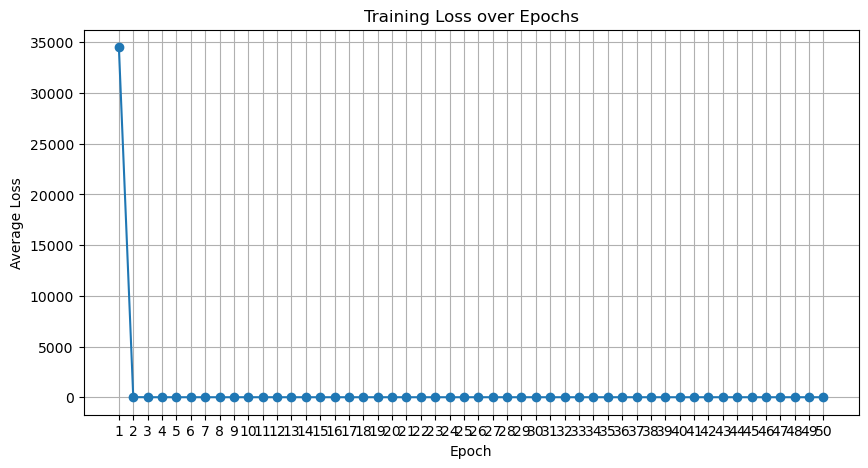

In [8]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=epochs):
    time_start = time()
    model.train()  # Set model to training mode
    epoch_losses = []  # List to store average loss for each epoch

    for epoch in range(epochs):
        total_loss = 0
        for features, labels in train_loader:
            labels = labels.type(torch.LongTensor)
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            outputs = outputs.reshape(outputs.size(0), -1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()           # reset gradient
            loss.backward()                 # automated backwards pass
            optimizer.step()                # take a step

            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)  # Store the average loss
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    time_stop = time()
    time_elapsed = time_stop - time_start
    print(f'Elapsed time {round(time_elapsed, 1)} sec.')

    # Plotting the loss over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.xticks(range(1, epochs + 1))
    plt.grid()
    plt.show()

# Call the training function
train_model(model, train_loader, criterion, optimizer, epochs=epochs)

In [9]:
# Testing loop
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.reshape(outputs.size(0), -1)
            _, predicted = torch.max(outputs.data, 1)         # predicted = index of maximum probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the test dataset: {accuracy:.2f}%')

test_model(model, test_loader)

Test Accuracy of the model on the test dataset: 7.01%


| Device | Dataset                   | Num Images | Image Size | Epochs | Batch Size | Accuracy (%) | Time (sec) |
|:-------|:--------------------------|:-----------|:-----------|:-------|:-----------|:-------------|:-----------|
| GPU    | Small_Just_Classes_Dataset| 1000       | 256x256    | 15     | 512        | 57.00        | 3.4        | 
| GPU    | AI_And_Classes            | 185015     | 256x256    | 15     | 512        | 74.42        | 660.8      |